In [1]:
%%time
import numpy as np
import pandas as pd
import timeit
import matplotlib.pyplot as plt
import seaborn as sns # for plotting
sns.set(color_codes=True) 
from scipy.spatial import distance_matrix
from ripser import ripser
from persim import plot_diagrams

start_time_all = timeit.default_timer()

samp_bead_density = 0.1
L        = 2000 # range of the domain for points in the data set
maxBetti = 1;

# Load the data
filenamex = "bead_dataxv_samp{}.csv".format(samp_bead_density)
filenamey = "bead_datayv_samp{}.csv".format(samp_bead_density)
filenamez = "bead_datazv_samp{}.csv".format(samp_bead_density)

allx = pd.read_csv(filenamex,header = None) 
ally = pd.read_csv(filenamey,header = None) 
allz = pd.read_csv(filenamez,header = None) 

nr_times = allx.shape[1]

Wall time: 3.38 s


In [2]:
# Functions
def m_births_deaths(time):  
    matx = allx[time] 
    maty = ally[time]
    matz = allz[time]

    # Combine coordinates into a matrix and calculate the persistence diagram of the Rips filtration built on top of the point cloud.
    data = pd.concat([matx,maty,matz], axis=1, sort=False)
    data = data.dropna()
    diagrams = ripser(data,maxdim=maxBetti,thresh=L)['dgms']
    m_birth_death = pd.DataFrame(diagrams[maxBetti])
    m_birth = m_birth_death[0]
    m_death = m_birth_death[1]
    return m_birth_death
    #plot_diagrams(diagrams, show=True)

def connection_btwn_two(ptsA,ptsB,cont_diff):  
    # Making matrix with distance between all the points in each time step
    num_ptsA = len(ptsA.index)
    num_ptsB = len(ptsB.index)
    distance_mat = distance_matrix(ptsA.values,ptsB.values)
  
    # Finding the closest points
    pairs_mat = []   
    
    # If there are no points in either time step
    if distance_mat.shape[1] == 0:
        for i in range(0,num_ptsA):
            pair = (i,np.nan)
            pairs_mat.append(pair)
        pairs_mat = np.asarray(pairs_mat)
        return(pairs_mat)
    elif distance_mat.shape[0] == 0:
        for j in range(0,num_ptsB):
            pair = (np.nan,j)
            pairs_mat.append(pair)  
        pairs_mat = np.asarray(pairs_mat)
        return(pairs_mat)
    
    if num_ptsA < num_ptsB:
        for i in range(0,num_ptsA):
            min_dist = np.nanmin(distance_mat[i,:])
            if min_dist < cont_diff:
                closest_B = np.nanargmin(distance_mat[i,:])
                distance_mat[i,:] = np.nan
                distance_mat[:,closest_B] = np.nan
                pair = (i,closest_B)
                pairs_mat.append(pair)
            else:
                distance_mat[i,:] = np.nan
                pair = (i,np.nan)
                pairs_mat.append(pair)
        pairs_mat = np.asarray(pairs_mat)
    
        for j in range(0,num_ptsB):
            if j not in pairs_mat[:,1]:
                pair = (np.nan,j)
                pairs_mat = np.vstack([pairs_mat,pair])                
    else: #if num_ptsA >= num_ptsB:
        for j in range(0,num_ptsB):
            min_dist = np.nanmin(distance_mat[:,j])
            if min_dist < cont_diff:
                closest_A = np.nanargmin(distance_mat[:,j])
                distance_mat[:,j] = np.nan
                distance_mat[closest_A,:] = np.nan
                pair = (closest_A,j)
                pairs_mat.append(pair)
            else:
                distance_mat[:,j] = np.nan
                pair = (np.nan,j)
                pairs_mat.append(pair)
        pairs_mat = np.asarray(pairs_mat)
     
        if num_ptsA>num_ptsB:
            for i in range(0,num_ptsA):
                if i not in pairs_mat[:,0]:
                    pair = (i,np.nan)
                    pairs_mat = np.vstack([pairs_mat,pair])

    return(pairs_mat)

def nanvalue(c,triangle_pts,index):
    if np.isnan(c):
        x = np.nan
    else:
        x = triangle_pts[index][c] 
    return x

In [3]:
%%time
# Calculate persistence diagram pairs for each time
list_bd = []
for time in range(0,201):
    m_birth_death = m_births_deaths(time)
    list_bd.append(m_birth_death)

Wall time: 4.85 s


In [4]:
%%time
## Get birth-death points for first time step 
triangle_pointsA = list_bd[0]
## Get birth-death points for second time step 
triangle_pointsB = list_bd[1]
cont_diff = 370 # Continuity difference, maximum distance we should still attach two triangles

## Set up connection matrices for the first two steps
ab = connection_btwn_two(triangle_pointsA,triangle_pointsB,cont_diff)
l_mat = ab
x_pairs = []
y_pairs = []
for k in range(0,len(ab)): 
    cA = ab[k,0]
    cB = ab[k,1]
    x_pair = (nanvalue(cA,triangle_pointsA,0),nanvalue(cB,triangle_pointsB,0)) #x_pair = (triangle_pointsA[0][cA],triangle_pointsB[0][cB])
    y_pair = (nanvalue(cA,triangle_pointsA,1),nanvalue(cB,triangle_pointsB,1)) #y_pair = (triangle_pointsA[1][cA],triangle_pointsB[1][cB])
    x_pairs.append(x_pair)
    y_pairs.append(y_pair) 
all_x_conn = np.asarray(x_pairs)
all_y_conn = np.asarray(y_pairs)

Wall time: 6 ms


In [5]:
%%time
# Connect all remaining steps through time
for time in range(1,200):  
     
    # Get birth-death points for first time step 
    triangle_pointsB = list_bd[time]    
    # Get birth-death points for second time step 
    triangle_pointsC = list_bd[time+1]

    # Connections to be added
    bc = connection_btwn_two(triangle_pointsB,triangle_pointsC,cont_diff) 

    # Sets up matrix for connections, indirectly handles death of orphans
    n_emp_row = np.empty((len(l_mat),1))
    n_emp_row[:] = np.nan
    l_mat = np.hstack((l_mat,n_emp_row))
    all_x_conn = np.hstack((all_x_conn,n_emp_row))
    all_y_conn = np.hstack((all_y_conn,n_emp_row))
    
    for p in range(0,len(bc)):
        cB = bc[p,0]
        cC = bc[p,1]
        
        ptBx = nanvalue(cB,triangle_pointsB,0)
        ptBy = nanvalue(cB,triangle_pointsB,1)
        ptCx = nanvalue(cC,triangle_pointsC,0)
        ptCy = nanvalue(cC,triangle_pointsC,1)
        
        if ~np.isnan(bc[p,0]):  # Matches up all pairs
            if bc[p,0] in l_mat[:,l_mat.shape[1]-2]:
                pos = np.where(l_mat[:,l_mat.shape[1]-2]==bc[p,0]) # returns a tuple
                l_mat[int(pos[0]),l_mat.shape[1]-1] = bc[p,1] # transform to one value (rather than array) and integer
                all_x_conn[int(pos[0]),all_x_conn.shape[1]-1] = ptCx
                all_y_conn[int(pos[0]),all_x_conn.shape[1]-1] = ptCy
                
            else:  # Handles birth of orphans
                orphan_birth    = np.empty((1,l_mat.shape[1]))
                orphan_birth[:] = np.nan
                orphan_birth[0,l_mat.shape[1]-1] = bc[p,1]
                l_mat           = np.vstack((l_mat,orphan_birth))
                
                orphan_birth_x    = np.empty((1,all_x_conn.shape[1]))
                orphan_birth_x[:] = np.nan
                orphan_birth_x[0,all_x_conn.shape[1]-1] = ptCx
                all_x_conn        = np.vstack((all_x_conn,orphan_birth_x))
                
                orphan_birth_y    = np.empty((1,all_y_conn.shape[1]))
                orphan_birth_y[:] = np.nan
                orphan_birth_y[0,all_y_conn.shape[1]-1] = ptCy
                all_y_conn        = np.vstack((all_y_conn,orphan_birth_y)) 

Wall time: 958 ms


In [6]:
%%time
# Determine significant path
max_dist_vec  = np.empty((1,l_mat.shape[1])); max_dist_vec[:]=np.nan
sig_index_vec = np.empty((1,l_mat.shape[1])); sig_index_vec[:]=np.nan

for col in range(0,l_mat.shape[1]):  
    dist_vec1  = np.empty((1,l_mat.shape[0])); dist_vec1[:]=np.nan
    for i in range(0,l_mat.shape[0]):
        if ~np.isnan(l_mat[i,col]):
            dist_vec1[0,i] = all_y_conn[i,col] - all_x_conn[i,col]
    
    if np.sum(~np.isnan(dist_vec1)) == 0:
        max_dist_vec[0,col]  = np.nan 
        sig_index_vec[0,col] = np.nan
    else:
        max_dist_vec[0,col]  = np.nanmax(dist_vec1) 
        sig_index_vec[0,col] = np.nanargmax(dist_vec1)            

max_dist = np.nanmax(max_dist_vec)
max_ind = np.nanargmax(max_dist_vec)
sig_path_index = sig_index_vec[0,max_ind]

Wall time: 292 ms


In [7]:
# Variables for distance versus time visualization
gt = 301.1 # Significance threshold
path_num = int(sig_path_index)
all_sig_pts_dist = all_y_conn[path_num,:]-all_x_conn[path_num,:]
all_sig_times = [10*x for x in range(0,len(all_x_conn[path_num,:]))]
all_diffs = all_sig_pts_dist - gt
last_neg_diff = np.max(np.where(all_diffs<0))
first_sig_time_index = 10*(last_neg_diff + 1)

C:\Users\veron\Anaconda3\envs\mlearn\lib\site-packages\ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in less
  import sys


In [8]:
# Plotting functions
def rbw_plot(all_x_conn,all_y_conn):
    plt.style.use('ggplot')
    #Plot the paths
    for path_num in range(0,all_x_conn.shape[0]):
        plt.plot(all_x_conn[path_num,:],all_y_conn[path_num,:])
    plt.plot(range(0,2000),range(0,2000),'k-')
    plt.xlabel('Birth')
    plt.ylabel('Death')
    plt.xlim(0,2000)
    plt.ylim(0,2000)
    plt.gca().set_aspect('equal', adjustable='box')

def sig_path_plot(all_x_conn,all_y_conn,sig_path):
    plt.style.use('ggplot')
    plt.plot(all_x_conn[sig_path,:],all_y_conn[sig_path,:],'b')
    plt.plot(range(0,2000),range(0,2000),'k-')
    plt.xlabel('Birth')
    plt.ylabel('Death')
    plt.xlim(0,2000)
    plt.ylim(0,2000)
    plt.gca().set_aspect('equal', adjustable='box')
    
def dvt_plot(all_sig_times,all_sig_pts_dist,gt,first_sig_time_index):
    plt.style.use('ggplot')  
    plt.scatter(all_sig_times,all_sig_pts_dist,c='b')
    plt.plot(range(0,2000),gt*np.ones(2000),'k--')
    plt.plot(first_sig_time_index*np.ones(1500),range(0,1500),'k--')
    plt.xlabel('Time')
    plt.ylabel('Significant feature persistence')
    plt.xlim(0,2000)
    plt.ylim(0,1500)
    plt.gca().set_aspect('equal', adjustable='box')
    
def rbw_sig_dvt_subplot(all_x_conn,all_y_conn,sig_path):
    plt.style.use('ggplot')
    fig, (ax1, ax2, ax3) = plt.subplots(1,3)
    plt.rcParams['figure.figsize'] = [20,12]
    plt.subplots_adjust(wspace=0.6)
    #Plot the paths
    for path_num in range(0,all_x_conn.shape[0]):
        ax1.plot(all_x_conn[path_num,:],all_y_conn[path_num,:])
    ax1.plot(range(0,2000),range(0,2000),'k-')
    ax1.set(xlabel='Birth', ylabel='Death')
    ax1.set_xlim([0,2000])
    ax1.set_ylim([0,2000])
    ax1.set_aspect('equal', adjustable='box')
    #Plot the significant path
    ax2.plot(all_x_conn[sig_path,:],all_y_conn[sig_path,:],'b')
    ax2.plot(range(0,2000),range(0,2000),'k-')
    ax2.set(xlabel='Birth', ylabel='Death')
    ax2.set_xlim([0,2000])
    ax2.set_ylim([0,2000])
    ax2.set_aspect('equal', adjustable='box')
    # Plot distance versus time 
    ax3.scatter(all_sig_times,all_sig_pts_dist,c='b')
    ax3.plot(range(0,2000),gt*np.ones(2000),'k--')
    ax3.plot(first_sig_time_index*np.ones(1500),range(0,1500),'k--')
    ax3.set(xlabel='Time', ylabel='Significant feature persistence')
    ax3.set_xlim([0,2000])
    ax3.set_ylim([0,1500])
    ax3.set_aspect('equal', adjustable='box')

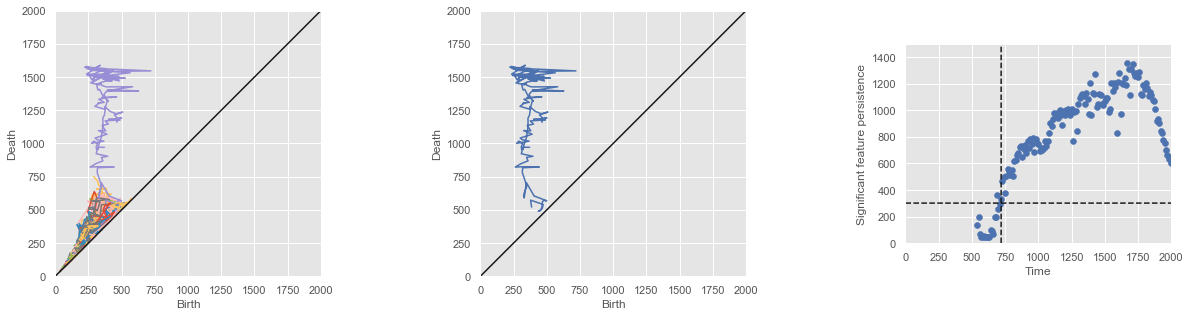

In [11]:
## Plotting - run this cell twice to see full-size figures
#rbw_plot(all_x_conn,all_y_conn)
#sig_path_plot(all_x_conn,all_y_conn,int(sig_path_index[0]))
#dvt_plot(all_sig_times,all_sig_pts_dist,gt,first_sig_time_index)
rbw_sig_dvt_subplot(all_x_conn,all_y_conn,path_num)

In [10]:
elapsed_all = timeit.default_timer() - start_time_all 
elapsed_all

8.0828049